/usr/local/lib/python3.12/dist-packages/torch/functional.py:554: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:4322.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


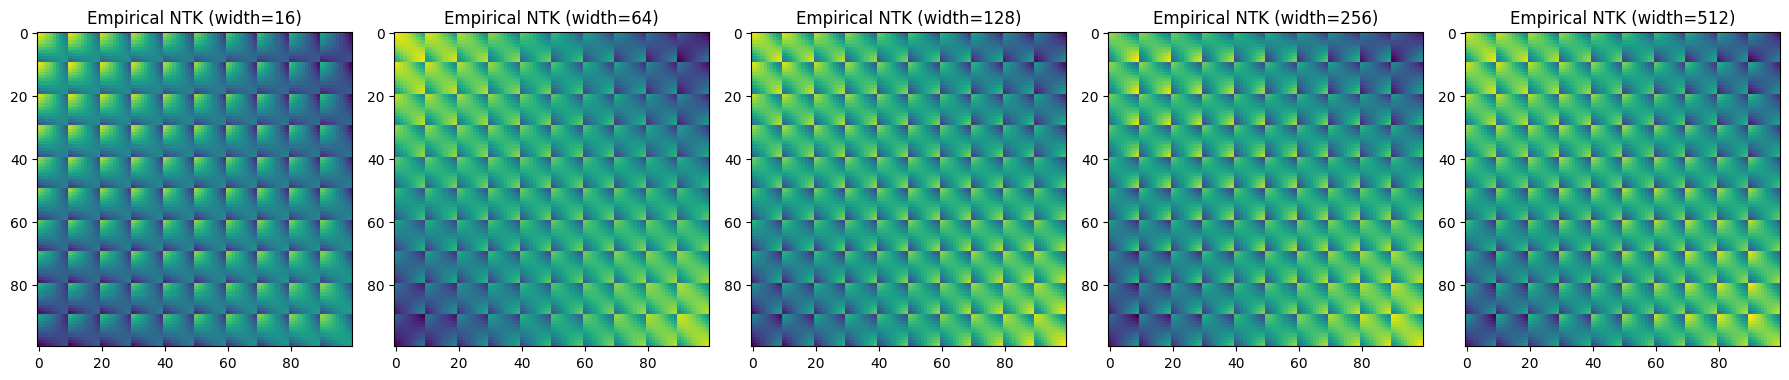

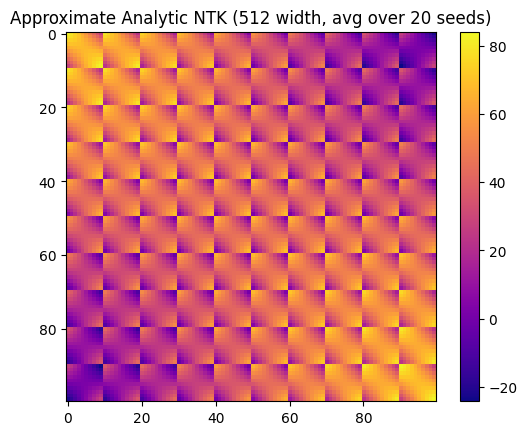

In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

#Create basic MLP
class MLP(nn.Module):
    def __init__(self, width, depth, activation=nn.Tanh):
        super().__init__()
        layers = []
        layers.append(nn.Linear(2, width))
        layers.append(activation())
        for _ in range(depth - 2):
            layers.append(nn.Linear(width, width))
            layers.append(activation())
        layers.append(nn.Linear(width, 1))
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)

#Define NTK
def empirical_ntk(model, x):
    n = x.shape[0]
    K = torch.zeros((n, n))
    params = [p for p in model.parameters() if p.requires_grad]

    for i in range(n):
        model.zero_grad()
        y_i = model(x[i:i+1])
        grads_i = torch.cat([g.contiguous().view(-1) for g in torch.autograd.grad(y_i, params, create_graph=True)])
        for j in range(i, n):
            y_j = model(x[j:j+1])
            grads_j = torch.cat([g.contiguous().view(-1) for g in torch.autograd.grad(y_j, params, retain_graph=True)])
            K_ij = torch.dot(grads_i, grads_j)
            K[i, j] = K_ij
            K[j, i] = K_ij
    return K.detach()

#Compare widths
torch.manual_seed(0)
x = torch.linspace(-1, 1, 10)
X = torch.stack(torch.meshgrid(x, x), dim=-1).reshape(-1, 2)  # 100 points

widths = [16, 64, 128, 256, 512]
Ks = []

for w in widths:
    model = MLP(width=w, depth=3, activation=nn.Tanh)
    K = empirical_ntk(model, X)
    Ks.append(K)

#Create HeatMaps of NTK at different widths
fig, axs = plt.subplots(1, len(widths), figsize=(18, 4))
for i, w in enumerate(widths):
    axs[i].imshow(Ks[i].numpy(), cmap='viridis')
    axs[i].set_title(f"Empirical NTK (width={w})")
plt.tight_layout()
plt.show()

#Create HeatMap of an average NTK
def averaged_ntk(width, repeats=20):
    Ks = []
    for _ in range(repeats):
        model = MLP(width=width, depth=3)
        Ks.append(empirical_ntk(model, X))
    return torch.stack(Ks).mean(0)

analytic_approx = averaged_ntk(width=512, repeats=20)

plt.imshow(analytic_approx.numpy(), cmap='plasma')
plt.title("Approximate Analytic NTK (512 width, avg over 20 seeds)")
plt.colorbar()
plt.show()


Computed NTK for width=16, depth=2
Computed NTK for width=64, depth=2
Computed NTK for width=16, depth=4
Computed NTK for width=64, depth=4


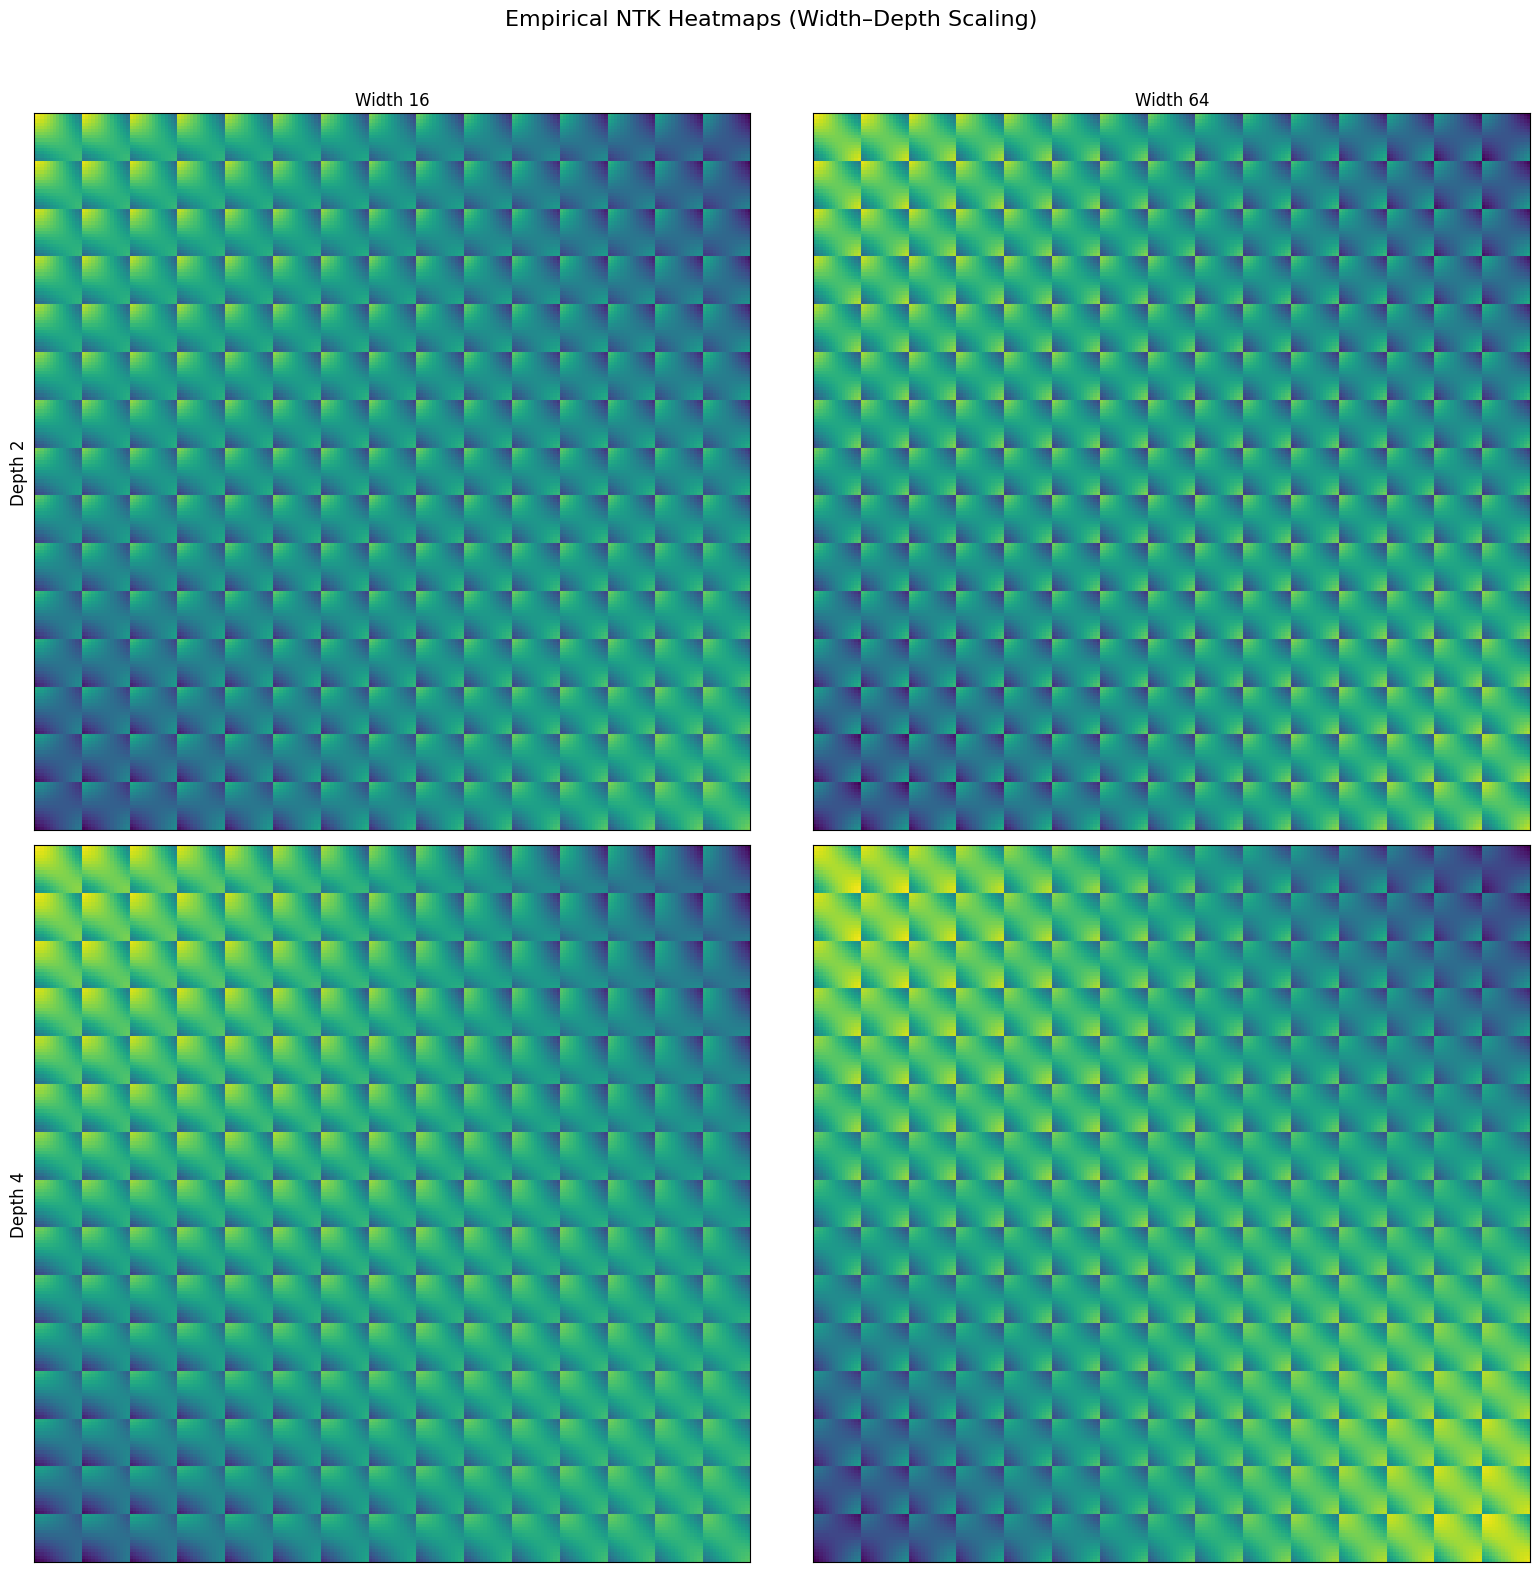

In [2]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

#Create basic MLP
class MLP(nn.Module):
    def __init__(self, width, depth, activation=nn.Tanh):
        super().__init__()
        layers = []
        layers.append(nn.Linear(2, width))
        layers.append(activation())
        for _ in range(depth - 2):
            layers.append(nn.Linear(width, width))
            layers.append(activation())
        layers.append(nn.Linear(width, 1))
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)

#Define NTK
def empirical_ntk(model, x):
    n = x.shape[0]
    K = torch.zeros((n, n))
    params = [p for p in model.parameters() if p.requires_grad]

    for i in range(n):
        model.zero_grad()
        y_i = model(x[i:i+1])
        grads_i = torch.cat([
            g.contiguous().view(-1)
            for g in torch.autograd.grad(y_i, params, create_graph=True)
        ])
        for j in range(i, n):
            y_j = model(x[j:j+1])
            grads_j = torch.cat([
                g.contiguous().view(-1)
                for g in torch.autograd.grad(y_j, params, retain_graph=True)
            ])
            K_ij = torch.dot(grads_i, grads_j)
            K[i, j] = K_ij
            K[j, i] = K_ij
    return K.detach()

#Define widths and depths
torch.manual_seed(0)

# Define input space (simple 1D grid embedded in 2D)
x = torch.linspace(-1, 1, 15)
X = torch.stack(torch.meshgrid(x, x), dim=-1).reshape(-1, 2)

widths = [16, 64]
depths = [2, 4]

#Create NTK with different values
results = {}
for d in depths:
    results[d] = []
    for w in widths:
        model = MLP(width=w, depth=d, activation=nn.Tanh)
        K = empirical_ntk(model, X)
        results[d].append(K)
        print(f"Computed NTK for width={w}, depth={d}")

#HeatMap of NTKs with depths + widths
fig, axs = plt.subplots(len(depths), len(widths), figsize=(16, 16))
for i, d in enumerate(depths):
    for j, w in enumerate(widths):
        ax = axs[i, j]
        ax.imshow(results[d][j].numpy(), cmap='viridis')
        if i == 0:
            ax.set_title(f"Width {w}")
        if j == 0:
            ax.set_ylabel(f"Depth {d}", fontsize=12)
        ax.set_xticks([]); ax.set_yticks([])
plt.suptitle("Empirical NTK Heatmaps (Width–Depth Scaling)", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


Computed NTK for activation: ReLU
Computed NTK for activation: Tanh
Computed NTK for activation: Sigmoid
Computed NTK for activation: GELU


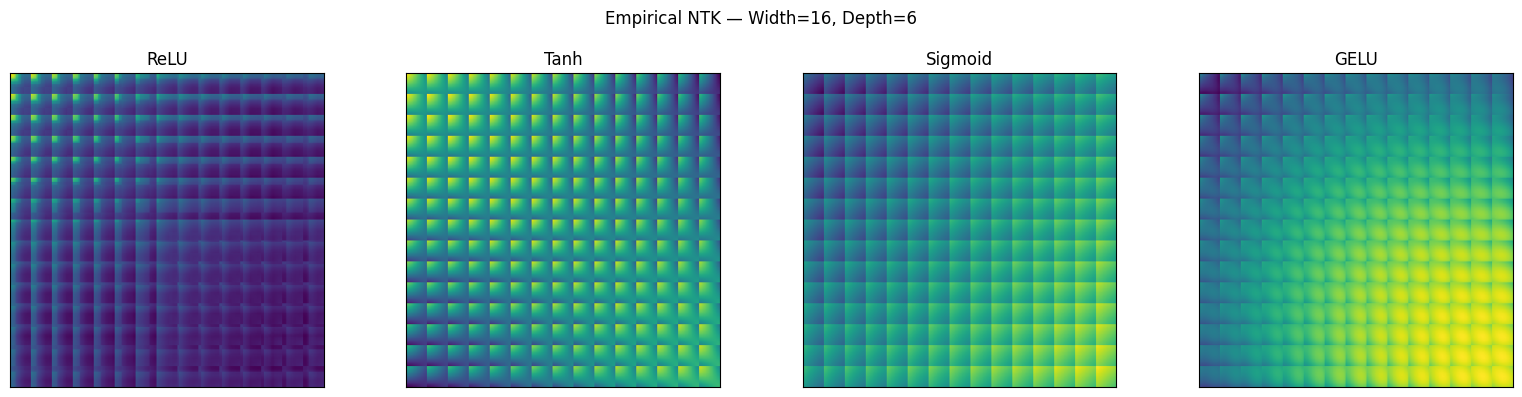

In [3]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

#Create basic MLP
class MLP(nn.Module):
    def __init__(self, width, depth, activation):
        super().__init__()
        layers = []
        layers.append(nn.Linear(2, width))
        layers.append(activation())
        for _ in range(depth - 2):
            layers.append(nn.Linear(width, width))
            layers.append(activation())
        layers.append(nn.Linear(width, 1))
        self.net = nn.Sequential(*layers)
    def forward(self, x):
        return self.net(x)

#Define NTK
def empirical_ntk(model, x):
    n = x.shape[0]
    K = torch.zeros((n, n))
    params = [p for p in model.parameters() if p.requires_grad]

    for i in range(n):
        model.zero_grad()
        y_i = model(x[i:i+1])
        grads_i = torch.cat([
            g.contiguous().view(-1)
            for g in torch.autograd.grad(y_i, params, create_graph=True)
        ])
        for j in range(i, n):
            y_j = model(x[j:j+1])
            grads_j = torch.cat([
                g.contiguous().view(-1)
                for g in torch.autograd.grad(y_j, params, retain_graph=True)
            ])
            K_ij = torch.dot(grads_i, grads_j)
            K[i, j] = K_ij
            K[j, i] = K_ij
    return K.detach()

#Activation functions at fixed depth + width
torch.manual_seed(0)
x = torch.linspace(-1, 1, 15)
X = torch.stack(torch.meshgrid(x, x), dim=-1).reshape(-1, 2)

width = 16
depth = 6
activations = [nn.ReLU, nn.Tanh, nn.Sigmoid, nn.GELU]

results = {}

#Run experiments
for act in activations:
    model = MLP(width, depth, act)
    K = empirical_ntk(model, X)
    results[act.__name__] = K
    print(f"Computed NTK for activation: {act.__name__}")

#Heatmap for different activations
fig, axs = plt.subplots(1, len(activations), figsize=(16, 4))
for i, act in enumerate(activations):
    K = results[act.__name__]
    axs[i].imshow(K.numpy(), cmap='viridis')
    axs[i].set_title(f"{act.__name__}")
    axs[i].set_xticks([]); axs[i].set_yticks([])
plt.suptitle(f"Empirical NTK — Width={width}, Depth={depth}")
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()